John Singer Sargent: Realism  
Edgar Degas: Impressionism  
Giovanni Battista Piranesi: Neoclassicism  
Claude Monet: Impressionism  
Raphael Kirchner: Art Noveau  
Salvador Dali: Surrealism  

In [2]:
import pandas as pd
import numpy as np
import sys
import re
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageChops, ImageOps

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [3]:
train_info = pd.read_csv('train_info.csv')
all_data_info = pd.read_csv('all_data_info.csv')

In [4]:
df = all_data_info.loc[all_data_info['artist'].isin(['John Singer Sargent', 'Edgar Degas', 'Giovanni Battista Piranesi', 'Claude Monet', 'Raphael Kirchner','Salvador Dali'])]

In [5]:
train = df[df['in_train']== True]
final_test = df[df['in_train']== False]

In [6]:
train = df[df['in_train']== True]
final_test = df[df['in_train']== False]

selected_jpgs = list(train.new_filename.values)

In [7]:
originals = "/Users/jenelleverrochi/Desktop/Capstone/train/"
rgb_images = "/Users/jenelleverrochi/Desktop/Capstone/6_artists/rgb_images/"
thumbs64 = "/Users/jenelleverrochi/Desktop/Capstone/6_artists/thumbs64/"
thumbs128 = "/Users/jenelleverrochi/Desktop/Capstone/6_artists/thumbs128/"

### Create thumbs

In [177]:
def makeThumb(f_in, f_out, size=(64,64)):    
    image = Image.open(f_in)
    image.thumbnail(size)
    image_size = image.size
    thumb = ImageOps.fit(image, size, Image.ANTIALIAS)
    thumb.save(f_out)

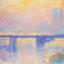

In [9]:
Image.open(thumbs64+'804.jpg')

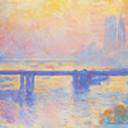

In [10]:
Image.open(thumbs128+'804.jpg')

Now that I have my images cropped, formatted, and saved on my desktop, I want to read them into my notebook as an array.

In [8]:
def get_array(jpg):
    pic = Image.open(thumbs64+jpg)
    array = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1],3)
    return array

In [9]:
train_array = []
for i in selected_jpgs:
    train_array.append(get_array(i))

In [10]:
print(len(train_array))
print(len(train_array[0]))
print(len(train_array[0][0]))
print(len(train_array[0][0][0]))

2254
64
64
3


In [11]:
train_array_2d = np.reshape(train_array, (2254,12288))

#### Pull in labels

In [12]:
train_df = pd.DataFrame(train_array_2d)

In [13]:
selected_jpgs_df = pd.DataFrame(selected_jpgs, columns=['jpg'])

In [14]:
train_df = pd.concat([train_df, selected_jpgs_df], axis=1)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,jpg
0,99,81,67,97,79,65,95,77,63,96,...,65,61,52,64,60,51,63,59,50,95360.jpg
1,171,171,143,176,176,148,173,176,147,167,...,105,126,119,112,132,123,121,141,132,49757.jpg
2,227,227,227,234,234,234,238,238,238,239,...,235,235,235,220,220,220,222,222,222,96147.jpg
3,232,232,232,232,232,232,232,232,232,231,...,235,235,235,236,236,236,239,239,239,11889.jpg
4,107,107,107,116,116,116,105,105,105,119,...,104,104,104,131,131,131,182,182,182,856.jpg


In [15]:
artist_df = all_data_info[['new_filename', 'artist']]
artist_df.columns = ['jpg', 'artist']

In [16]:
train_df = pd.merge(train_df, artist_df, on='jpg', how='left')
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12280,12281,12282,12283,12284,12285,12286,12287,jpg,artist
0,99,81,67,97,79,65,95,77,63,96,...,61,52,64,60,51,63,59,50,95360.jpg,Edgar Degas
1,171,171,143,176,176,148,173,176,147,167,...,126,119,112,132,123,121,141,132,49757.jpg,Claude Monet
2,227,227,227,234,234,234,238,238,238,239,...,235,235,220,220,220,222,222,222,96147.jpg,Giovanni Battista Piranesi
3,232,232,232,232,232,232,232,232,232,231,...,235,235,236,236,236,239,239,239,11889.jpg,Giovanni Battista Piranesi
4,107,107,107,116,116,116,105,105,105,119,...,104,104,131,131,131,182,182,182,856.jpg,Giovanni Battista Piranesi


In [17]:
train_df.artist.value_counts()

Giovanni Battista Piranesi    402
Edgar Degas                   387
Claude Monet                  383
John Singer Sargent           377
Raphael Kirchner              357
Salvador Dali                 348
Name: artist, dtype: int64

In [21]:
train_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,12280,12281,12282,12283,12284,12285,12286,12287,jpg,artist
0,99,81,67,97,79,65,95,77,63,96,...,61,52,64,60,51,63,59,50,95360.jpg,Edgar Degas
1,171,171,143,176,176,148,173,176,147,167,...,126,119,112,132,123,121,141,132,49757.jpg,Claude Monet
2,227,227,227,234,234,234,238,238,238,239,...,235,235,220,220,220,222,222,222,96147.jpg,Giovanni Battista Piranesi
3,232,232,232,232,232,232,232,232,232,231,...,235,235,236,236,236,239,239,239,11889.jpg,Giovanni Battista Piranesi
4,107,107,107,116,116,116,105,105,105,119,...,104,104,131,131,131,182,182,182,856.jpg,Giovanni Battista Piranesi
5,202,202,202,206,206,206,209,209,209,209,...,181,181,192,192,192,187,187,187,67325.jpg,Giovanni Battista Piranesi
6,150,175,135,158,185,142,130,159,115,81,...,133,34,129,127,16,119,127,5,41682.jpg,Claude Monet
7,143,178,180,142,177,179,139,177,178,139,...,149,110,103,131,91,69,106,65,37256.jpg,Claude Monet
8,147,147,147,172,172,172,166,166,166,159,...,178,178,181,181,181,153,153,153,94943.jpg,Giovanni Battista Piranesi
9,160,160,160,167,167,167,180,180,180,190,...,199,199,210,210,210,210,210,210,23452.jpg,Giovanni Battista Piranesi


### Train Test Split

In [537]:
X = train_df.iloc[:,:-2]
y = train_df.iloc[:,-1]

In [538]:
y = pd.get_dummies(y)

In [539]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [540]:
X_train = X_train/255.
X_test = X_test/255.

In [541]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1690, 12288)
(564, 12288)
(1690, 6)
(564, 6)


### CNN

In [542]:
#must reshape to grid for cnn

X_train = X_train.reshape(X_train.shape[0], 64, 64, 3)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)

In [24]:
from keras.models import load_model

In [25]:
model1 = load_model('model1.h5')

In [26]:
model2 = load_model('model2.h5')

In [543]:
X_4d = np.reshape(np.array(X), (2254,64, 64, 3))

In [493]:
model1.evaluate(X_4d, y)

2254/2254 [==============================] - 6s 3ms/step


[6.1378279932854758, 0.61535048802129544]

In [495]:
model3.evaluate(X_4d, y)

2254/2254 [==============================] - 6s 3ms/step


[6.6520116824587312, 0.57453416133201962]

In [496]:
model2.evaluate(X_4d, y)

2254/2254 [==============================] - 5s 2ms/step


[9.9523005339960768, 0.38464951197870451]

### Manual Confusion Matrix

In [485]:
#on training set

In [486]:
y_hat = model2.predict_classes(X_4d)

2254/2254 [==============================] - 6s 2ms/step


In [341]:
y.head()

,Claude Monet,Edgar Degas,Giovanni Battista Piranesi,John Singer Sargent,Raphael Kirchner,Salvador Dali
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [344]:
#4
rk = prediction_df[prediction_df['artist']== 'Raphael Kirchner']
print(rk.prediction.value_counts())
print(357/357)

4    357
Name: prediction, dtype: int64
1.0


In [346]:
#5
sd = prediction_df[prediction_df['artist']== 'Salvador Dali']
print(sd.prediction.value_counts())
print(60/(159+152+27+5+4+1))

4    246
5     60
3     32
1      5
0      3
2      2
Name: prediction, dtype: int64
0.1724137931034483


In [348]:
#3
jss = prediction_df[prediction_df['artist']== 'John Singer Sargent']
print(jss.prediction.value_counts())
print(278/(278+70+21+6+1+1))

4    225
3    127
5     22
1      2
2      1
Name: prediction, dtype: int64
0.7374005305039788


In [349]:
#1
ed = prediction_df[prediction_df['artist']== 'Edgar Degas']
print(ed.prediction.value_counts())
print(117/(184+117+43+43))

4    335
3     22
5     15
1     14
0      1
Name: prediction, dtype: int64
0.3023255813953488


In [350]:
#2
gbp = prediction_df[prediction_df['artist']== 'Giovanni Battista Piranesi']
print(gbp.prediction.value_counts())
print(363/(363+27+10+2))

2    270
4    109
5     15
3      8
Name: prediction, dtype: int64
0.9029850746268657


In [351]:
#0
cm = prediction_df[prediction_df['artist']== 'Claude Monet']
print(cm.prediction.value_counts())
print(115/(115+143+57+39+29))

4    290
0     39
5     33
3     14
1      5
2      2
Name: prediction, dtype: int64
0.3002610966057441


In [322]:
#Total Accuracy

(355/357)
(159/(159+152+27+5+4+1))
(278/(278+70+21+6+1+1))
(117/(184+117+43+43))
(363/(363+27+10+2))
(115/(115+143+57+39+29))

0.3002610966057441

In [323]:
(355 + 159 + 278+ 117 + 363 +115)/2254

0.6153504880212954

In [325]:
prediction_df.shape

(2254, 12291)

### Make a folder of test images

In [169]:
final_test.shape

(721, 12)

In [170]:
test_jpgs = list(final_test.new_filename.values)

In [171]:
len(test_jpgs)

721

In [172]:
test_originals = "/Users/jenelleverrochi/Desktop/test/"
test_rgb = "/Users/jenelleverrochi/Desktop/Capstone/6_artists/test_rgb/"
test_64 = "/Users/jenelleverrochi/Desktop/Capstone/6_artists/test_thumbs64/"

In [174]:
for f in test_jpgs:
    Image.open(test_originals+f).convert('RGB').save(test_rgb+f)

In [179]:
for f in test_jpgs:
    makeThumb((test_rgb+f), (test_64+f))

### Make array and df

In [182]:
def get_test_array(jpg):
    pic = Image.open(test_64+jpg)
    array = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1],3)
    return array

In [183]:
test_array = []
for i in test_jpgs:
    test_array.append(get_test_array(i))

In [411]:
print(len(test_array))
print(len(test_array[0]))
print(len(test_array[0][0]))
print(len(test_array[0][0][0]))

721
64
64
3


In [428]:
test_array_2d = np.reshape(test_array, (721,12288))

In [429]:
test_array_2d.shape

(721, 12288)

In [430]:
test_array_4d = np.reshape(test_array_2d, (721,64, 64, 3))

In [431]:
test_df = pd.DataFrame(test_array_2d)
test_jpg_df = pd.DataFrame(test_jpgs, columns=['jpg'])

In [432]:
test_jpg_df.shape

(721, 1)

In [433]:
test_df.shape

(721, 12288)

In [434]:
test_df = pd.concat((test_df, test_jpg_df), axis=1)

In [438]:
test_df.shape

(721, 12289)

In [439]:
test_df = pd.merge(test_df, artist_df, on='jpg', how='left')
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12280,12281,12282,12283,12284,12285,12286,12287,jpg,artist
0,191,194,247,192,195,246,193,197,245,193,...,138,76,133,141,82,134,143,86,35919.jpg,Claude Monet
1,199,199,199,200,200,200,201,201,201,199,...,198,198,203,203,203,200,200,200,85670.jpg,Giovanni Battista Piranesi
2,118,118,118,120,120,120,115,115,115,118,...,235,235,237,237,237,242,242,242,19571.jpg,Giovanni Battista Piranesi
3,78,78,78,133,133,133,173,173,173,187,...,225,225,224,224,224,235,235,235,57901.jpg,Giovanni Battista Piranesi
4,193,193,193,192,192,192,189,189,189,187,...,225,225,223,223,223,219,219,219,97939.jpg,Giovanni Battista Piranesi


In [440]:
test_df.shape

(721, 12290)

### Split X and y

In [532]:
Xt = test_df.iloc[:,:-2]
yt = test_df['artist']

In [533]:
yt = pd.get_dummies(yt)

In [534]:
Xt = np.array(Xt)
yt = np.array(yt)

In [453]:
Xt.shape

(721, 12288)

In [454]:
Xt_4d = np.reshape(Xt, (721,64, 64,3))

In [455]:
score = model2.evaluate(Xt_4d, yt)
score

721/721 [==============================] - 2s 2ms/step


[9.9233070879802625, 0.38418862698974293]

In [379]:
y_hat_test = model2.predict_classes(test_array_4d)

721/721 [==============================] - 2s 2ms/step


In [459]:
y_hat_test.prediction.value_counts()

4    513
3     73
2     73
5     47
0     10
1      5
Name: prediction, dtype: int64

In [461]:
test_df_pred = pd.concat((test_df, y_hat_df), axis=1)

In [462]:
test_df_pred.shape

(721, 12291)

In [463]:
test_df_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,12281,12282,12283,12284,12285,12286,12287,jpg,artist,predictions
0,191,194,247,192,195,246,193,197,245,193,...,76,133,141,82,134,143,86,35919.jpg,Claude Monet,4
1,199,199,199,200,200,200,201,201,201,199,...,198,203,203,203,200,200,200,85670.jpg,Giovanni Battista Piranesi,2
2,118,118,118,120,120,120,115,115,115,118,...,235,237,237,237,242,242,242,19571.jpg,Giovanni Battista Piranesi,3
3,78,78,78,133,133,133,173,173,173,187,...,225,224,224,224,235,235,235,57901.jpg,Giovanni Battista Piranesi,2
4,193,193,193,192,192,192,189,189,189,187,...,225,223,223,223,219,219,219,97939.jpg,Giovanni Battista Piranesi,2


In [464]:
test_df_pred.artist.value_counts()

Raphael Kirchner              140
Salvador Dali                 137
John Singer Sargent           123
Claude Monet                  115
Edgar Degas                   108
Giovanni Battista Piranesi     98
Name: artist, dtype: int64

In [239]:
y.head()

,Claude Monet,Edgar Degas,Giovanni Battista Piranesi,John Singer Sargent,Raphael Kirchner,Salvador Dali
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [468]:
#4
rkt = test_df_pred[test_df_pred['artist']== 'Raphael Kirchner']
print(rkt.predictions.value_counts())
print(132/140)

4    132
5      4
3      3
2      1
Name: predictions, dtype: int64
0.9428571428571428


In [469]:
#5
sdt = test_df_pred[test_df_pred['artist']== 'Salvador Dali']
print(sdt.predictions.value_counts())
print(40/137)

4    67
5    40
3    19
1     6
2     4
0     1
Name: predictions, dtype: int64
0.291970802919708


### Model 3

In [27]:
model3 = load_model('model3.h5')

In [29]:
from keras.utils import plot_model

In [30]:
plot_model(model3, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

In [470]:
y_hat3 = model3.predict_classes(test_array_4d)

721/721 [==============================] - 2s 3ms/step


In [471]:
y_hat3

array([4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       2, 2, 2, 2, 2, 3, 2, 2, 4, 4, 0, 4, 4, 5, 5, 4, 4, 4, 2, 1, 4, 4, 4,
       2, 4, 1, 4, 4, 4, 4, 4, 4, 4, 2, 2, 0, 0, 1, 0, 5, 0, 5, 5, 4, 4, 3,
       2, 0, 2, 5, 5, 1, 4, 5, 1, 5, 4, 4, 4, 5, 4, 3, 4, 2, 4, 4, 4, 0, 1,
       5, 4, 4, 0, 0, 4, 4, 4, 2, 4, 3, 2, 4, 4, 4, 4, 4, 4, 0, 5, 4, 4, 0,
       0, 4, 2, 4, 4, 4, 4, 4, 4, 2, 0, 0, 3, 0, 1, 0, 0, 0, 4, 4, 0, 5, 4,
       5, 0, 4, 4, 4, 0, 5, 4, 4, 5, 4, 4, 4, 0, 4, 4, 3, 5, 4, 2, 0, 4, 0,
       0, 2, 4, 4, 4, 5, 2, 0, 4, 0, 4, 4, 4, 5, 4, 4, 4, 0, 4, 0, 5, 3, 2,
       4, 4, 1, 1, 4, 0, 2, 4, 1, 4, 2, 0, 3, 2, 4, 4, 2, 4, 4, 2, 3, 5, 2,
       3, 2, 2, 3, 2, 2, 4, 5, 4, 5, 4, 4, 4, 5, 2, 2, 0, 0, 5, 4, 4, 5, 4,
       4, 2, 2, 1, 0, 5, 5, 2, 0, 2, 3, 5, 5, 2, 2, 4, 5, 5, 2, 2, 2, 2, 3,
       2, 2, 2, 0, 2, 2, 0, 5, 2, 0, 2, 2, 0, 2, 4, 1, 2, 5, 0, 2, 0, 3, 4,
       0, 2, 2, 2, 4, 0, 2, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3,
       2, 2,

### Test set evals

In [498]:
score1 = model1.evaluate(Xt_4d, yt)
score1

721/721 [==============================] - 2s 3ms/step


[8.0729200309258733, 0.49791955617198336]

In [503]:
score2 = model2.evaluate(Xt_4d, yt)
score2

721/721 [==============================] - 2s 2ms/step


[9.9233070879802625, 0.38418862698974293]

In [504]:
score3 = model3.evaluate(Xt_4d, yt)
score3

721/721 [==============================] - 2s 2ms/step


[7.7746173988268215, 0.50624133156671935]

In [507]:
score4 = model4.evaluate(Xt_4d, yt)
score4

721/721 [==============================] - 2s 2ms/step


[9.7452758868094449, 0.38141470188572074]

In [510]:
model5.evaluate(Xt_4d, yt)

721/721 [==============================] - 2s 2ms/step


[9.3629577192949363, 0.42441054099806469]

In [514]:
model6.evaluate(Xt_4d, yt)

721/721 [==============================] - 2s 2ms/step


[7.7455638500709405, 0.50346740638002774]

In [523]:
model7.evaluate(Xt_4d, yt)

721/721 [==============================] - 2s 3ms/step


[9.4552625732808977, 0.41192787794729541]

### Train set evals

In [500]:
model1.evaluate(X_4d, y)

2254/2254 [==============================] - 6s 3ms/step


[6.1378279932854758, 0.61535048802129544]

In [501]:
model2.evaluate(X_4d, y)

2254/2254 [==============================] - 6s 3ms/step


[9.9523005339960768, 0.38464951197870451]

In [502]:
model3.evaluate(X_4d, y)

2254/2254 [==============================] - 5s 2ms/step


[6.6520116824587312, 0.57453416133201962]

In [506]:
model4.evaluate(X_4d, y)

2254/2254 [==============================] - 6s 3ms/step


[9.6595670555477771, 0.39219165911374099]

In [509]:
model5.evaluate(X_4d, y)

2254/2254 [==============================] - 6s 2ms/step


[8.209729397538867, 0.49423247559893524]

In [513]:
model6.evaluate(X_4d, y)

2254/2254 [==============================] - 6s 3ms/step


[6.6958785373399392, 0.57187222715173025]

In [522]:
model7.evaluate(X_4d, y)

2254/2254 [==============================] - 6s 3ms/step


[9.8873763176486129, 0.38509316770186336]

### Load Models

In [505]:
model4 = load_model('model4.h5')

In [508]:
model5 = load_model('model5.h5')

In [512]:
model6 = load_model('model6.h5')

In [521]:
model7 = load_model('model7.h5')

### Predictions using model 3

In [525]:
y_hat3 = model3.predict_classes(Xt_4d)

721/721 [==============================] - 2s 3ms/step


In [526]:
y_hat3_df = pd.DataFrame(y_hat3, columns= ['predictions'])

In [527]:
test_df_pred = pd.concat((test_df, y_hat_df), axis=1)

In [558]:
test_df_pred.predictions.value_counts()

4    336
3    117
2    112
5     99
0     31
1     26
Name: predictions, dtype: int64

In [544]:
y.head()

,Claude Monet,Edgar Degas,Giovanni Battista Piranesi,John Singer Sargent,Raphael Kirchner,Salvador Dali
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [546]:
test_df_pred.artist.value_counts()

Raphael Kirchner              140
Salvador Dali                 137
John Singer Sargent           123
Claude Monet                  115
Edgar Degas                   108
Giovanni Battista Piranesi     98
Name: artist, dtype: int64

In [562]:
108/721

0.14979195561719832

In [547]:
#0
cm = test_df_pred[test_df_pred['artist']== 'Claude Monet']
print(cm.predictions.value_counts())
print(26/115)

4    41
0    26
5    22
2    15
3     9
1     2
Name: predictions, dtype: int64
0.22608695652173913


In [549]:
#1
ed = test_df_pred[test_df_pred['artist']== 'Edgar Degas']
print(ed.predictions.value_counts())
print(16/108)

4    56
3    21
1    16
5    14
0     1
Name: predictions, dtype: int64
0.14814814814814814


In [551]:
#2
gbp = test_df_pred[test_df_pred['artist']== 'Giovanni Battista Piranesi']
print(gbp.predictions.value_counts())
print(86/98)

2    86
3     6
4     4
5     1
0     1
Name: predictions, dtype: int64
0.8775510204081632


In [553]:
#3
jss = test_df_pred[test_df_pred['artist']== 'John Singer Sargent']
print(jss.predictions.value_counts())
print(59/123)

3    59
4    36
5    18
2     6
1     2
0     2
Name: predictions, dtype: int64
0.4796747967479675


In [554]:
#4
rkt = test_df_pred[test_df_pred['artist']== 'Raphael Kirchner']
print(rkt.predictions.value_counts())
print(132/140)

4    132
5      4
3      3
2      1
Name: predictions, dtype: int64
0.9428571428571428


In [556]:
#5
sd = test_df_pred[test_df_pred['artist']== 'Salvador Dali']
print(sd.predictions.value_counts())
print(40/137)

4    67
5    40
3    19
1     6
2     4
0     1
Name: predictions, dtype: int64
0.291970802919708


In [559]:
#Total Accuracy:
(26+16+40+86+59+132)/721

0.49791955617198336

### Score Model 3 using 2 artists

In [564]:
df_kirchner_piranesi = all_data_info.loc[all_data_info['artist'].isin(['Giovanni Battista Piranesi', 'Raphael Kirchner'])]

In [583]:
train_kp = df_kirchner_piranesi[df_kirchner_piranesi['in_train']== True]
final_test_kp = df_kirchner_piranesi[df_kirchner_piranesi['in_train']== False]

kirchner_piranesi_jpgs = list(final_test_kp.new_filename.values)

In [584]:
test_array_kp = []
for i in kirchner_piranesi_jpgs:
    test_array_kp.append(get_test_array(i))

In [614]:
len(test_array_kp)

238

In [615]:
test_array_2d_kp = np.reshape(test_array_kp, (238,12288))

In [616]:
test_df_kp = pd.DataFrame(test_array_2d_kp)

In [617]:
test_df_kp.shape

(238, 12288)

In [618]:
kirchner_piranesi_jpgs_df = pd.DataFrame(kirchner_piranesi_jpgs, columns=['jpg'])

In [619]:
kirchner_piranesi_jpgs_df.shape

(238, 1)

In [620]:
test_df_kp = pd.concat([test_df_kp, kirchner_piranesi_jpgs_df], axis=1)
test_df_kp.shape

(238, 12289)

In [621]:
test_df_kp = pd.merge(test_df_kp, artist_df, on='jpg', how='left')
test_df_kp.shape

(238, 12290)

In [622]:
X = test_df_kp.iloc[:,:-2]
y = test_df_kp.artist

In [623]:
y = pd.get_dummies(y)

In [627]:
X = np.array(X)
y = np.array(y)

In [634]:
X_4d = np.reshape(np.array(X), (238,64, 64, 3))

### Model 2 Classes

In [22]:
model3

NameError: name 'model3' is not defined